In [1]:
from ast import Pass
import math
import copy
from operator import index
import numpy as np
import matplotlib.pyplot as plt

### Clases

##### Clase Nodo

In [2]:
class Node:

    indice = 1 

    def __init__(self, coord, restricciones=[0,0,0]):
        
        self.indice = Node.indice
        self.coord = coord
        self.restricciones = restricciones
        self.n_DoF = 0. 
        self.u = [] 

        Node.indice += 1 

    def __str__(self): 
        return "("+str(self.x1)+","+str(self.x2)+")" 

In [3]:
n1 = Node([1, 0 ],[1,1,1])
n2 = Node([3, 0 ],[1,0,0])
n3 = Node([6, 0 ],[1,1,1])
n4 = Node([1, 9 ],[0,0,0])
n5 = Node([3, 9 ],[0,0,0])
n6 = Node([6, 9 ],[0,0,0])
n7 = Node([3, 15],[0,0,0])
n8 = Node([6, 15],[0,0,0])

##### Clase Elemento

In [4]:
class MaterialIsotropicoLineal:
    def __init__(self, E):
        self.E = E
         
class Elemento:
    indice = 1
    def __init__(self, nodes):
        self.indice = Elemento.indice
        self.nodes = nodes
        Elemento.indice += 1

##### Clase Elemento_Portico

In [5]:
class ElementoPortico(Elemento, MaterialIsotropicoLineal):

    def __init__(self, nodes, E, A, I):

        self.L = 0 
        self.A = A
        self.I = I
        self.K = np.array(np.zeros([6,6]))

        Elemento.__init__(self, nodes)
        MaterialIsotropicoLineal.__init__(self,E)
        
        if self.nodes[0].n_DoF == 0: self.nodes[0].n_DoF = 3
        if self.nodes[1].n_DoF == 0: self.nodes[1].n_DoF = 3

        self.calcularLongitud()
        self.K_porticoGlobal() 

    # Cálculo de la longitud en términos de las coordenadas
    
    def calcularLongitud(self):
        
        ni = self.nodes[0]
        nj = self.nodes[1]

        self.L = math.sqrt((nj.coord[0] - ni.coord[0])**2 + (nj.coord[1] - ni.coord[1])**2)
        self.theta = math.atan2((nj.coord[1] - ni.coord[1]),(nj.coord[0] - ni.coord[0]))

    # Cálculo de la matriz de rigidez del elemento en coordenadas globales.
    
    def K_porticoGlobal(self):
        
        c = math.cos(self.theta) 
        s = math.sin(self.theta) 

        T = np.zeros([6,6])
        T = np.matrix(T)
        
        T[0,0] = c
        T[0,1] = s
        T[1,0] = -s
        T[1,1] = c
        T[2,2] = 1
        T[3,3] = c
        T[3,4] = s
        T[4,3] = -s
        T[4,4] = c
        T[5,5] = 1

        EAL = self.E*self.A/self.L
        EI= self.E*self.I

        l = self.L

        k = np.zeros([6,6])
        k = np.matrix(k)

        k[0,0] =  EAL
        k[0,3] = -EAL
        k[1,1] =  12 * EI/l**3
        k[1,2] =   6 * EI/l**2
        k[1,4] = -12 * EI/l**3
        k[1,5] =   6 * EI/l**2
        k[2,1] =   6 * EI/l**2
        k[2,2] =   4 * EI/l
        k[2,4] = - 6 * EI/l**2
        k[2,5] =   2 * EI/l
        k[3,0] = -EAL
        k[3,3] =  EAL
        k[4,1] = -12*EI/l**3
        k[4,2] = - 6*EI/l**2
        k[4,4] =  12*EI/l**3
        k[4,5] = - 6*EI/l**2
        k[5,1] =   6*EI/l**2
        k[5,2] =   2*EI/l
        k[5,4] = - 6*EI/l**2
        k[5,5] =   4*EI/l 

        self.K = np.transpose(T) * k * T

    def plot(self,ax):
        
        ni = self.nodes[0]
        nj = self.nodes[1]

        # Extracción de coordenadas nodo inicial
        xi = ni.coord[0]
        yi = ni.coord[1]

        # Extracción de coordenadas nodo final
        xj = nj.coord[0]
        yj = nj.coord[1]

        # Traza en el eje "ax" la línea del elemento. Se debe pasar el eje.
        ax.plot([xi, xj], [yi, yj], 'k-o') 

In [6]:
E=2e8
A=0.2*0.5
I=0.2*(0.5**3)/12

e1 = ElementoPortico([n1,n4],E,A,I)
e2 = ElementoPortico([n2,n5],E,A,I)
e3 = ElementoPortico([n3,n5],E,A,I)
e4 = ElementoPortico([n3,n6],E,A,I)
e5 = ElementoPortico([n5,n7],E,A,I)
e6 = ElementoPortico([n6,n8],E,A,I)
e7 = ElementoPortico([n4,n5],E,A,I)
e8 = ElementoPortico([n5,n6],E,A,I)
e9 = ElementoPortico([n7,n8],E,A,I)

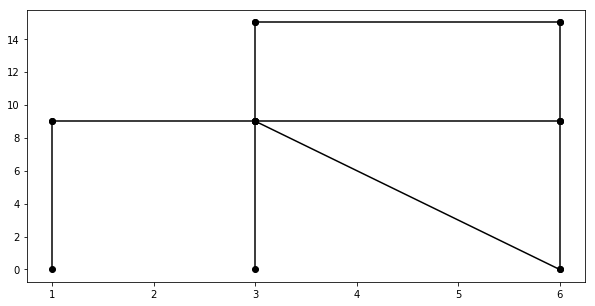

In [7]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)

e1.plot(ax)
e2.plot(ax)
e3.plot(ax)
e4.plot(ax)
e5.plot(ax)
e6.plot(ax)
e7.plot(ax)
e8.plot(ax)
e9.plot(ax)

##### Clase Estructura

In [8]:
class Structure:

    def __init__(self, nodos, elementos):
        
        self.nodes = nodos
        self.elementos = elementos

        n_DoF = 3*len(nodos) 

        self.n_DoF = n_DoF

        self.K    = np.array(np.zeros([n_DoF, n_DoF]))
        self.resV = np.array(np.zeros([n_DoF,1])) # Vector de restricciones.

        self.extraerRestricciones()
        self.ensambleK()

    def ensambleK(self):
        
        for elem in self.elementos: 
            
            ni = elem.nodes[0].indice - 1 # índice de nodo inicial
            nj = elem.nodes[1].indice - 1 # Índice de nodo final

            inicialI = 3*ni
            finalI = 3*ni + 2

            inicialJ = 3*nj
            finalJ = 3*nj + 2

            self.K[inicialI:finalI+1,inicialI:finalI+1] += elem.K[0:3,0:3]
            self.K[inicialJ:finalJ+1,inicialJ:finalJ+1] += elem.K[3:6,3:6]

            self.K[inicialI:finalI+1,inicialJ:finalJ+1] += elem.K[0:3,3:6]
            self.K[inicialJ:finalJ+1,inicialI:finalI+1] += elem.K[3:6,0:3]

    def extraerRestricciones(self):
        
        resMat = [] 

        for n in self.nodes:
            resMat.append(n.restricciones)

        resMat =np.array(resMat)

        self.resV = resMat.flatten() # Convierte matriz en lista.

        self.rest_index = np.where(self.resV != 0)[0] 
        self.free_index = np.where(self.resV == 0)[0] 

    def extraer_subK(self):

        Knn = [[self.K[i][j] for j in self.free_index] for i in self.free_index]
        Kaa = [[self.K[i][j] for j in self.rest_index] for i in self.rest_index]
        Kan = [[self.K[i][j] for j in self.rest_index] for i in self.free_index]
        Kna = [[self.K[i][j] for j in self.free_index] for i in self.rest_index]

        self.Knn = np.array(Knn)
        self.Kaa = np.array(Kaa)
        self.Kan = np.array(Kan)
        self.Kna = np.array(Kna) 

    def plot(self,ax):
        
        for e in self.elementos:
            e.plot(ax)

#         ax.set_aspect('equal', 'box')

In [9]:
s = Structure([n1,n2,n3,n4,n5,n6,n7,n8],[e1,e2,e3,e4,e5,e6,e7,e8,e9])

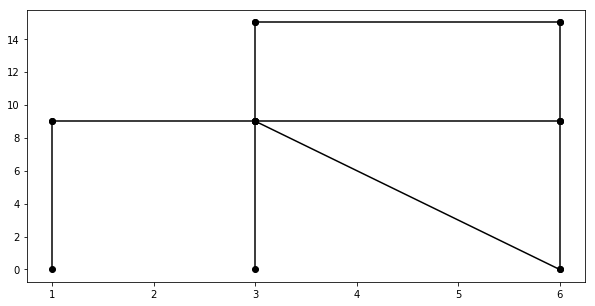

In [10]:
fig1 = plt.figure(figsize=(10,5))

ax1 = fig1.add_subplot(111)

s.plot(ax1)

##### Clase Modelo (Static)

In [11]:
class Model:
    def __init__(self ,struct):
        
        self.S = struct
        self.F = np.array(np.zeros([self.S.n_DoF])) #Vector de fuerzas.
        self.u = np.array(np.zeros([self.S.n_DoF])) #Vector de desplazamientos 

    def add_node_displacement(self, node_index, displacement): 

        pos_1 = 3*(node_index-1)
        pos_2 = 3*(node_index-1)+2

        self.F[pos_1:pos_2+1] += displacement[0:3]


    def add_node_force(self, node_index, force): 

        pos_1 = 3*(node_index-1)
        pos_2 = 3*(node_index-1)+2

        self.F[pos_1:pos_2+1] += force[0:3]

    def extraer_Fn(self): 
        self.Fn = [self.F[index] for index in self.S.free_index]

    def extraer_ua(self): 
        self.ua = [self.u[index] for index in self.S.rest_index]


    def set_displacements(self): 

        for i, index in enumerate(self.S.free_index):
            self.u[index] = self.un[i]

        for i, index in enumerate(self.S.rest_index):
            self.u[index] = self.ua[i]

        for i, node in enumerate(self.S.nodes):

            for j in range(node.n_DoF):
                node.u.append(self.u[3*i+j])

    def solve(self):        
        self.extraer_Fn()
        self.extraer_ua()
        self.S.extraer_subK() # Extrae matrices Knn de la estructura.

        # Cálculo de los desplazamientos.
        self.un = np.linalg.solve(self.S.Knn , self.Fn - np.matmul(self.S.Kan, self.ua))

        # Cálculo de las reacciones.
        self.Fa = np.matmul(self.S.Kna, self.un) + np.matmul(self.S.Kaa, self.ua)

        # Ensamble del vector total de desplazamientos.
        self.set_displacements()


    def plot_deformed(self,ax,ampFactor): 
        S_updated = copy.deepcopy(self.S)  #Create a new structure to modify his nodes. (copy)

        for n in S_updated.nodes:
            n.coord[0] += ampFactor*n.u[0] # Se aplifican los desplazamientos para que sean visibles.
            n.coord[1] += ampFactor*n.u[1] 
            
        self.S.plot(ax)
        S_updated.plot(ax)

In [12]:
m = Model(s)

In [13]:
m.add_node_force(5,[50, 0, 0])
m.solve()

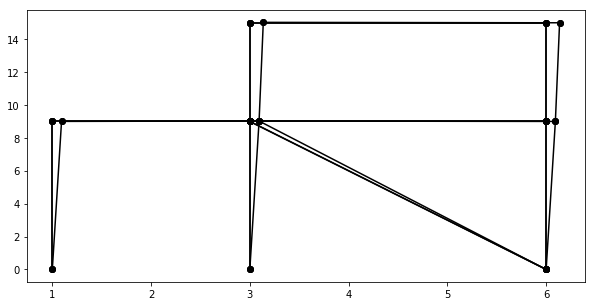

In [14]:
fig2 = plt.figure(figsize=(10,5))

ax2 = fig2.add_subplot(111)

m.plot_deformed(ax2,100)
s.plot(ax2)